# Fast Fourier Transform
### Set values for whether you would like to generate new results or just use the JSON that has previously been generated

In [1]:
# Set to true if you want to run the tests again. Otherwise just loads results from JSON
GENERATE_NEW_RESULTS = False

# Set to true if you want to save figures to disk. Change path as needed
SAVE_FIGURES_TO_DISK = False
FIG_SAVE_PATH = "../../thesis/figures/fft/"

Load in packages and set options for prettier plots

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.9)

import numpy as np
import concurrent.futures
import json

from helper_funcs import save_fig, make_cache, get_val_arr, \
                         print_table_nums, hit_to_misses, \
                         MORTON, ROW_ARR, BLOCK_ARR

from data_structures.morton_order import MortonOrder
from data_structures.block_array import BlockArray
from data_structures.row_major_array import RowMajorArray

from algorithms.fft import fftn

In [3]:
matplotlib.rcParams['figure.figsize'] = (9.0, 4.8)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

## Defining functions/variables to run tests

In [4]:
def rand_complex_array(*args):
    return np.random.rand(*args) + 1j * np.random.rand(*args)


def results_for_size_and_typ(vals):
    n, rnd_vals, str_rep = vals

    cs = make_cache()

    if str_rep == MORTON:
        data = MortonOrder(rnd_vals, cache=cs)
    elif str_rep == BLOCK_ARR:
        data = BlockArray(rnd_vals, cache=cs)
    else:
        data = RowMajorArray(rnd_vals, cache=cs)

    # Warm up
    fftn(data)

    # Reset caches
    cs.force_write_back()
    cs.reset_stats()

    # Do actual test
    fftn(data)

    print(f"{n} -- {str_rep} finished")
    cs.force_write_back()
    return list(cs.stats()), str_rep
    

def results_for_arr_size(n_dim):
    n, dim = n_dim
    print(n)
    rnd_vals = rand_complex_array(n, n) if dim == 2 else rand_complex_array(n, n, n)
    vals = [(n, rnd_vals, str_rep) for str_rep in [MORTON, ROW_ARR, BLOCK_ARR]]    
    results = {}
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for (res, str_rep) in executor.map(results_for_size_and_typ, vals):
            if res is not None:
                results[str_rep] = res
    return results, n

In [5]:
ns_2d = [2**i for i in range(4, 12)]
print(ns_2d)

#ns_3d = [2**i for i in range(3, 9)]
ns_3d = [2**i for i in range(3, 9)]
print(ns_3d)

[16, 32, 64, 128, 256, 512, 1024, 2048]
[8, 16, 32, 64, 128, 256]


## Generating/loading in test results

### 2D

In [6]:
if GENERATE_NEW_RESULTS:
    dim = 2
    ns_dim = [(n, dim) for n in ns_2d]
    results_2d = {}
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for (res, n) in executor.map(results_for_arr_size, ns_dim):
            results_2d[n] = res
            
    with open('results/fft-result-2d.json', 'w') as f:
        json.dump(results_2d, f, indent=4)
else:
    with open('results/fft-result-2d.json', 'r') as f:
        results_2d = json.load(f)

### 3D

In [7]:
if GENERATE_NEW_RESULTS:
    dim = 3
    ns_dim = [(n, dim) for n in ns_3d]
    results_3d = {}
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for (res, n) in executor.map(results_for_arr_size, ns_dim):
            results_3d[n] = res
    
    with open('results/fft-result-3d.json', 'w') as f:
        json.dump(results_3d, f, indent=4)
else:
    with open('results/fft-result-3d.json', 'r') as f:
        results_3d = json.load(f)

### Plotting

In [8]:
def make_plot(dim, cache_level=0, stat="HIT_count", loc=4):
    results = results_2d if dim == 2 else results_3d
    labels = ns_2d if dim == 2 else ns_3d

    row_arr_res = get_val_arr(results, ROW_ARR, stat=stat)
    morton_res = get_val_arr(results, MORTON, stat=stat) / row_arr_res
    block_arr_res = get_val_arr(results, BLOCK_ARR, stat=stat) / row_arr_res
    row_arr_res = row_arr_res / row_arr_res # All 1's

    x = np.arange(len(labels))  # the label locations
    width = 0.20  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, morton_res, width, label="MortonOrder")
    rects2 = ax.bar(x, row_arr_res, width, label="RowMajorArray")
    rects3 = ax.bar(x + width, block_arr_res, width, label="BlockArray")

    stat_simple_label = stat.lower().replace("_", " ")
    ax.set_ylabel(f"Relatve {stat_simple_label}")
    ax.set_xlabel("$n$")
    #ax.set_title(f"Relatve {stat} (scaled by RowMajorArray) during {dim}D FFT")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc=loc)

    fig.tight_layout()
    save_fig(f"{stat}-{dim}d.pdf", FIG_SAVE_PATH, SAVE_FIGURES_TO_DISK)

    plt.show()

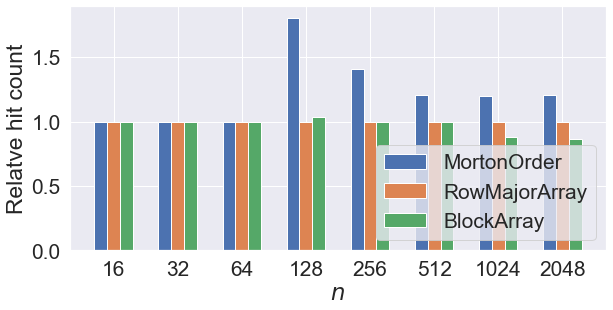

In [9]:
make_plot(2)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


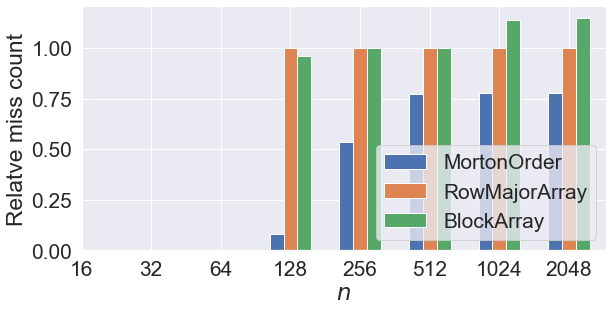

In [10]:
make_plot(2, stat="MISS_count", loc=4)

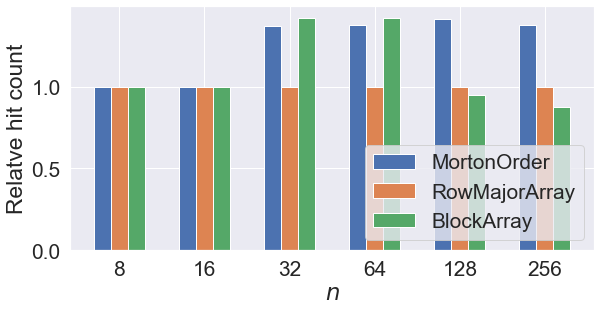

In [11]:
make_plot(3)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


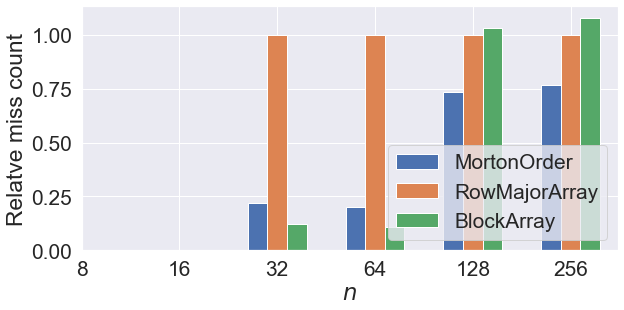

In [12]:
make_plot(3, stat="MISS_count", loc=4)

### Numbers used in report for table:

In [13]:
for stat in ["HIT_count", "MISS_count"]:
    print(stat)
    for dim, results, ns in zip([2, 3], [results_2d, results_3d], [ns_2d, ns_3d]):
        print_table_nums(dim, results, ns, stat)
        
print("HIT_TO_MISS")
for dim, results, ns in zip([2, 3], [results_2d, results_3d], [ns_2d, ns_3d]):
    hit_to_misses(dim, results, ns)

HIT_count
Dim: 2
ns        : [16, 32, 64, 128, 256, 512, 1024, 2048]
morton    : 1.00 & 1.00 & 1.00 & 1.80 & 1.41 & 1.20 & 1.20 & 1.20
block_arr : 1.00 & 1.00 & 1.00 & 1.04 & 1.00 & 1.00 & 0.88 & 0.87


Dim: 3
ns        : [8, 16, 32, 64, 128, 256]
morton    : 1.00 & 1.00 & 1.37 & 1.38 & 1.42 & 1.37
block_arr : 1.00 & 1.00 & 1.42 & 1.42 & 0.95 & 0.87


MISS_count
Dim: 2
ns        : [16, 32, 64, 128, 256, 512, 1024, 2048]
morton    : nan & nan & nan & 0.08 & 0.54 & 0.77 & 0.78 & 0.77
block_arr : nan & nan & nan & 0.96 & 1.00 & 1.00 & 1.14 & 1.15


Dim: 3
ns        : [8, 16, 32, 64, 128, 256]
morton    : nan & nan & 0.22 & 0.20 & 0.74 & 0.77
block_arr : nan & nan & 0.12 & 0.11 & 1.03 & 1.08


HIT_TO_MISS
Dim: 2
ns        : [16, 32, 64, 128, 256, 512, 1024, 2048]
morton    : inf & inf & inf & 24.85 & 2.99 & 1.75 & 1.72 & 1.72
row_arr   : inf & inf & inf & 1.14 & 1.14 & 1.12 & 1.12 & 1.11
block_arr : inf & inf & inf & 1.23 & 1.14 & 1.12 & 0.86 & 0.83


Dim: 3
ns        : [8, 16, 32, 64, 128

/Users/shmulvad/GoogleDrive/Uni/Bachelorprojekt/code/src/helper_funcs.py:69: RuntimeWarning: invalid value encountered in true_divide
  rel_res = get_val_arr(results, data_typ, stat=stat) / row_arr_res
/Users/shmulvad/GoogleDrive/Uni/Bachelorprojekt/code/src/helper_funcs.py:83: RuntimeWarning: divide by zero encountered in true_divide
  hit_to_misses = map(lambda val: f"{val:.2f}", hits / misses)
